In [2]:
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot

#### Load functions

In [3]:
#%% Import libraries
import pandas as pd
import numpy as np
import sys
import pyfixest as pf
from tqdm import tqdm
import pickle

from pyfixest.estimation import feols
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

sys.path += ['../src/'] 
import utils
import config


# 40 seconds
abm_path = "ISP_data_for_ABM/ISP_ABM_up_to_2024_08_0001.csv"
data = pd.read_csv(jl_vae.path_intermediate + abm_path, index_col = 0)
geo_dict = jl_vae.load_geo_data()

# these need to be added to the generated data for predicting with hedonic regression
year_erogaz = [f'year_erogaz_{u}' for u in [u for u in range(2016, 2025)]] 
# Trained Hedonic Regression
train_path = '/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_OMI_id.pkl'
# Load ISP data for the ABM and clean it 
data_path = '/data/housing/data/intermediate/ISP_data_for_ABM/ISP_ABM_up_to_2024_08.csv'
isp = pd.read_csv(data_path,dtype=str,encoding='latin1',na_values=config.default_missing)

drop_col = ['floor_numeric','NUM_MQ_SUPERF_COMM','COD_CAT_CATASTALE','year_erogaz']
isp = isp.drop(columns=drop_col)
isp = utils.CorrectTypes_ABM(isp)

def HedonicRegression_PriceTrain (train_data,sp_fix_eff,save):
    """
    Function to compute the hedonic price of the houses in the synthetic population
    Inputs:
     - train_data: ISP data
     - sp_fix_eff: spatial fixed effects (we start using PRO_COM)
     - save: flag that is True if you want to save the regression parameters in this file f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl'. 

    Outputs:
     - reg_risk: regression objetc
    """
    # Drop colinearity variables
    drop_coliniarity= ['ANNO_COSTRUZIONE_1500_1965','Medium_energy_class',
                        'COD_CAT_A_04_05','floor_0.0','year_erogaz_2016']
    train_data = train_data.drop(columns=drop_coliniarity)

    # Add dummies to formula: 
    floor_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('floor_')]))
    year_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('year_erogaz_20')]))
    energy_class_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('_energy_class')]))
    ANNO_COSTRUZIONE_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('ANNO_COSTRUZIONE')]))
    COD_CAT_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('COD_CAT_')]))

    dummies_vec = COD_CAT_dummies + '+' + ANNO_COSTRUZIONE_dummies + '+' + energy_class_dummies + ' + ' + floor_dummies + '+' + year_dummies

    # Regression specification
    base_features = 'flag_garage + flag_pertinenza + flag_air_conditioning + flag_multi_floor +' + dummies_vec
    mq_feature = 'log_mq' 

    eq_regr_risk = 'log_price ~ scenario_Risk +' + mq_feature + '+' + base_features + '|' +  sp_fix_eff  # + C(month_erogaz) year_erogaz_prov +
    
    # Train regression
    reg_risk = feols(fml=eq_regr_risk, data=train_data, drop_intercept=False ,vcov = {"CRV1":sp_fix_eff})
    if save==True:
        model_state = {"_beta_hat": reg_risk._beta_hat,
                    "_coefnames": reg_risk._coefnames,
                    "_se": reg_risk._se,
                    "_tstat": reg_risk._tstat,
                    "_pvalue": reg_risk._pvalue,
                    "_conf_int": reg_risk._conf_int,
                    "_vcov": reg_risk._vcov,
                    "_fml": reg_risk._fml,
                    "_sumFE": reg_risk._sumFE,
                    "_fixef": reg_risk._fixef,
                    "_fixef_dict": reg_risk._fixef_dict,
                    "_data": reg_risk._data}
        with open(f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl', 'wb') as handle:
            pickle.dump(model_state, handle)

    return reg_risk

def Predict_function(isp,train_path,test_data):
    """
    Function to estimate the hedonic price of a house. 

    Input variables:
        -isp: data from ISP data (used to initialize the regression model)
        - train_path: path to coefficients af the trained model
        - test_data: data for which you want to estimate the home hedonic price

    Output:
        - test_data: same Dataframe as the input with the estimated hedonic price corrected by inflation
    and flood_risk effects (``price_corrected``). 
    """

    # Initialise dummy regresion
    reg_risk = HedonicRegression_PriceTrain(isp.sample(1000),'PRO_COM',save=False)

    # Update reg_risk with good params
    with open(train_path, 'rb') as handle:
        model_state = pickle.load(handle)

    reg_risk._beta_hat = model_state["_beta_hat"]
    reg_risk._coefnames = model_state["_coefnames"]
    reg_risk._se = model_state["_se"]
    reg_risk._tstat = model_state["_tstat"]
    reg_risk._pvalue = model_state["_pvalue"]
    reg_risk._conf_int = model_state["_conf_int"]
    reg_risk._vcov = model_state["_vcov"]
    reg_risk._fml = model_state["_fml"]
    reg_risk._sumFE = model_state["_sumFE"]
    reg_risk._fixef = model_state["_fixef"]
    reg_risk._fixef_dict = model_state["_fixef_dict"]
    reg_risk._data = model_state["_data"]

    test_data['log_price_estimation'] = reg_risk.predict(test_data)

    
    # Correct price estimations with Risk coefficient and average Inflation
    _, df_coeff = utils.ImportantCoefficients(reg_risk,['Risk'])

    # Risk correction
    test_data['price_corrected'] = test_data['log_price_estimation'] - (df_coeff.loc['scenario_Risk','Coefficient']*test_data['scenario_Risk'])

    # Correct inflation
    df_year,_ = utils.ImportantCoefficients(reg_risk,['year']) # av_inflation
    avg_inflation = df_year.Coefficient.mean()
    
    for i in df_year.index:
        test_data['price_corrected'] = test_data['price_corrected'] - (df_year.loc[i,'Coefficient']*test_data[i])
    test_data['price_corrected'] = test_data['price_corrected'] + avg_inflation
    
    # Remove log and drop unnecessary columns
    test_data['price_corrected'] = np.exp(test_data['price_corrected'])
    test_data.drop(columns='log_price_estimation',inplace=True)
    
        
    return test_data
    


In [4]:
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df


### One province

In [5]:
# choose the province
prov = "BZ"
# get the cod prov (number)
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].item()

# all trained models have these settings
date_nf = "241203"
date_vae = "240107"
date_data = "250110"

real_pops = jl_vae.path_pop_synth + f"pop_samples/pop_real_with_hedonic_price"
synth_pops = jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250110"

vae_data = "full"

date_abl = "250523"
ablation_pops = jl_vae.path_pop_synth + f"pop_samples_ablation"

In [9]:
df_real = pd.read_csv(real_pops + f"/pop_real_full_250110{prov}.csv", index_col = 0)
df_sample_all = pd.read_csv(synth_pops + f"/pop_synth_full_250110{prov}.csv", index_col = 0).query("prov_abbrv == @prov")
df_real = add_cat_features(df_real)
df_sample_all = add_cat_features(df_sample_all)
df_sample = df_sample_all.sample(n = int(len(df_real)), random_state = 1111)
# df_abl = pd.read_csv(ablation_pops + f"/synthetic_pop_{vae_data}_{date_abl}{prov}.csv", index_col = 0).sample(n = int(len(df_real)), replace = True, random_state = 1111)
# df_sample_abl = (df_abl_with_price.query("COD_PROV == @cod_prov").sample(n = int(len(df_real)), random_state = 1111)
#                  .assign(CAP = lambda x: x["CAP"].astype(int),
#                          PRO_COM = lambda x: x["PRO_COM"].astype(int)))

In [11]:
df_sample.columns

Index(['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing', 'y_latent',
       'x_latent', 'x_norm', 'y_norm', 'x', 'y', 'COD_CONTRATTO', 'SEZ2011',
       'PRO_COM', 'flag_geo_valid', 'CAP', 'OMI_id', 'OMI_categ', 'scenario',
       'scenario_MediumRisk', 'scenario_NoRisk', 'scenario_HighRisk',
       'scenario_LowRisk', 'scenario_Risk', 'flag_italy', 'COD_PROV',
       'COD_REG', 'regione_nome', 'prov_nome', 'prov_abbrv',
       'year_erogaz_prov', 

In [8]:
df_real.columns

Index(['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'y', 'x', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4', 'x_norm',
       'y_norm', 'flag_air_conditioning_Missing', 'flag_multi_floor_Missing',
       'y_latent', 'x_latent', 'COD_CONTRATTO', 'SEZ2011', 'PRO_COM',
       'flag_geo_valid', 'CAP', 'OMI_id', 'OMI_categ', 'scenario',
       'scenario_MediumRisk', 'scenario_NoRisk', 'scenario_HighRisk',
       'scenario_LowRisk', 'scenario_Risk', 'flag_italy', 'COD_PROV',
       'COD_REG', 'regione_nome', 'prov_nome', 'prov_abbrv',
       'year_erogaz_prov', 

In [13]:
df_sub = df_real.assign(log_price = lambda x: np.log(x["price_corrected"]))[['flag_garage', 'flag_pertinenza', 
        'flag_air_conditioning',
       'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing', 'y_latent',
       'x_latent','log_price']]

In [41]:
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata

<bound method BaseSingleTableSynthesizer.reset_sampling of <sdv.single_table.copulas.GaussianCopulaSynthesizer object at 0x7fce78a27590>>

In [38]:
metadata = Metadata.detect_from_dataframe(df_sub)
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_sub)


In [ ]:
synthesizer.reset_sampling()
df_copula = synthesizer.sample(num_rows=len(df_sub))
df_copula["log_mq"]

0       4.472864
1       4.319958
2       5.189411
3       4.220099
4       4.638497
          ...   
1578    4.566155
1579    4.618407
1580    4.592271
1581    3.677498
1582    4.272208
Name: log_mq, Length: 1583, dtype: float64

In [18]:
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict

date = "241203" + prov
path_nf = jl_vae.path_pop_synth + f"nf_models/nf_{date}.pkl"
            
nf_dict = load_dict(path_nf)


In [19]:
transf_xy = nfg.nf_latent_to_real(nf_dict, np.array(df_sample[["y_latent", "x_latent"]].astype(np.float32)))
df_sample["y_trans"] = transf_xy[:,0]
df_sample["x_trans"] = transf_xy[:,1]

transf_xy = nfg.nf_latent_to_real(nf_dict, np.array(df_real[["y_latent", "x_latent"]].astype(np.float32)))
df_real["y_trans"] = transf_xy[:,0]
df_real["x_trans"] = transf_xy[:,1]

transf_xy = nfg.nf_latent_to_real(nf_dict, np.array(df_copula[["y_latent", "x_latent"]].astype(np.float32)))
df_copula["y_trans"] = transf_xy[:,0]
df_copula["x_trans"] = transf_xy[:,1]


In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
scaler = MinMaxScaler((-1,1))
scaler.fit(np.array(df_real[["x", "y"]]))
df_sample[["x_trans2", "y_trans2"]] = scaler.inverse_transform(np.array(df_sample[["x_trans", "y_trans"]]))
df_real[["x_trans2", "y_trans2"]] = scaler.inverse_transform(np.array(df_real[["x_trans", "y_trans"]]))
df_copula[["x_trans2", "y_trans2"]] = scaler.inverse_transform(np.array(df_copula[["x_trans", "y_trans"]]))

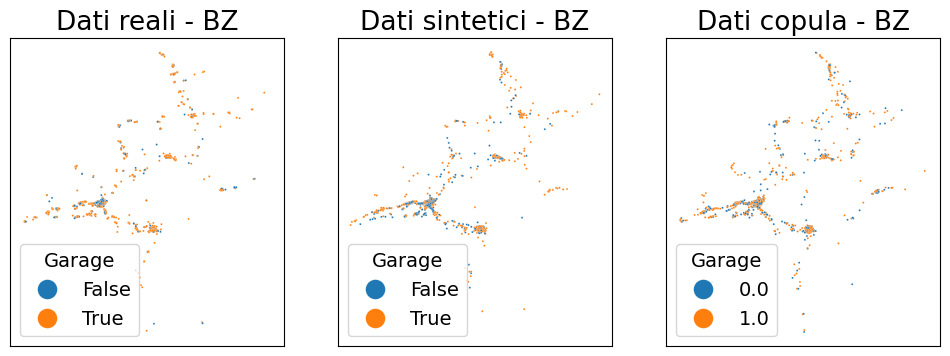

In [22]:
fig, axes = sbp(ncols = 3, figsize = (12,4), sharex = True, sharey = True)

for j,df_plot in enumerate([df_real.assign(flag_garage = lambda x: x["flag_garage"] == 1), 
                            df_sample, 
                            df_copula]):
    sns.scatterplot(data = df_plot,
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x_trans2", y = "y_trans2", s = 2, ax = axes[j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[j].set_title("Dati " + ["reali", "sintetici", "copula"][j] + " - " + prov, fontsize = 19)
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
# axes[0].legend().set_visible(False)
    axes[j].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")

In [24]:
df_copula.columns

Index(['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing', 'y_latent',
       'x_latent', 'log_price', 'y_trans', 'x_trans', 'x_trans2', 'y_trans2'],
      dtype='object')

In [36]:
np.random.seed(23)
synthesizer.sample(num_rows=3, random_state = 2)["log_price"]

TypeError: BaseSingleTableSynthesizer.sample() got an unexpected keyword argument 'random_state'

In [26]:
jl_vae.path_pop_synth

'/data/housing/data/intermediate/jl_pop_synth/'

In [25]:
[['flag_garage', 'flag_pertinenza', 
        'flag_air_conditioning',
       'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing', 'y_latent',
       'x_latent','log_price']]

[['flag_garage',
  'flag_pertinenza',
  'flag_air_conditioning',
  'flag_multi_floor',
  'log_mq',
  'ANNO_COSTRUZIONE_1500_1965',
  'ANNO_COSTRUZIONE_1965_1985',
  'ANNO_COSTRUZIONE_1985_2005',
  'ANNO_COSTRUZIONE_2005_2025',
  'ANNO_COSTRUZIONE_Missing',
  'High_energy_class',
  'Low_energy_class',
  'Medium_energy_class',
  'Missing_energy_class',
  'COD_CAT_A02',
  'COD_CAT_A03',
  'COD_CAT_A_01_07_08',
  'COD_CAT_A_04_05',
  'floor_0.0',
  'floor_1.0',
  'floor_2.0',
  'floor_3.0',
  'floor_Missing',
  'floor_plus_4',
  'flag_air_conditioning_Missing',
  'flag_multi_floor_Missing',
  'y_latent',
  'x_latent',
  'log_price']]

In [ ]:
import pandas as pd
import numpy as np
from ipfn import ipfn

# 1. Load your df as given

# 2. Create bins & marginals
df['x_bin'] = pd.qcut(df['x'], q=10, labels=False)
df['y_bin'] = pd.qcut(df['y'], q=10, labels=False)

agg_x = df['x_bin'].value_counts().sort_index()
agg_y = df['y_bin'].value_counts().sort_index()
agg_bool1 = df['bool_1'].value_counts().sort_index()
# [... repeat for other variables ...]

aggregates = [agg_x.values, agg_y.values, agg_bool1.values, ...]
dimensions = [['x_bin'], ['y_bin'], ['bool_1'], ...]

# 3. Run IPF
orig = df[['x_bin','y_bin','bool_1', ...]]  # only constraint columns
ipf = ipfn(orig, aggregates, dimensions)
res = ipf.iteration(max_iteration=500, convergence_rate=1e-5)
weights = res.df

# 4. Weighted sampling
weights['prob'] = weights['weight'] / weights['weight'].sum()
synthetic_df = df.sample(
    n=len(df),
    replace=True,
    weights=weights['prob']
).reset_index(drop=True)


In [56]:
prov = "AN"

In [57]:
df1 = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/real_populations/df_real_{prov}.csv", index_col = 0)
real_pops = jl_vae.path_pop_synth + f"pop_samples/pop_real_with_hedonic_price"
df_real_ = pd.read_csv(real_pops + f"/pop_real_full_250110{prov}.csv", index_col = 0)
# df_real_ = add_cat_features(df_real_)
df2 = df_real_.assign(log_price = lambda x: x["price_corrected"], CAP = lambda x: x["CAP"].astype(str))
